# Assignment 3: Crop Yield Prediction using Machine Learning

## 1. Problem Definition and Business Context

### 1.1 Business Problem
Agricultural productivity is crucial for food security and economic sustainability. Farmers and agricultural planners need accurate predictions of crop yields to:
- Optimize resource allocation (fertilizers, water, labor)
- Make informed decisions about crop selection
- Plan harvest and storage logistics
- Manage market supply and pricing

### 1.2 Dataset Overview
The Crop Yield dataset contains historical agricultural data with the following features:
- **Environmental factors**: Temperature, Humidity, Wind Speed
- **Soil properties**: Soil Type, Soil pH, Soil Quality
- **Nutrients**: Nitrogen (N), Phosphorus (P), Potassium (K)
- **Target variable**: Crop_Yield (tons per hectare)

### 1.3 Machine Learning Objective
Build a **supervised regression model** to predict crop yield based on environmental and soil conditions. This enables:
1. Accurate yield forecasting for planning purposes
2. Understanding which factors most influence crop productivity
3. Identifying optimal conditions for maximum yield

### 1.4 Success Metrics
We will evaluate models using:
- **RMSE (Root Mean Squared Error)**: Penalizes large prediction errors heavily
- **MAE (Mean Absolute Error)**: Average magnitude of errors in yield predictions
- **R² (Coefficient of Determination)**: Proportion of variance explained by the model

These metrics are appropriate for regression tasks where we need to understand both average error magnitude (MAE) and the impact of outliers (RMSE), while R² indicates overall model fit.

## 2. Library Imports

We import comprehensive libraries for:
- Data manipulation (pandas, numpy)
- Visualization (matplotlib, seaborn)
- Machine learning (scikit-learn)
- Model interpretation (SHAP)
- Statistical analysis (scipy)

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve

# Machine learning - models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Feature selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# Explainable AI
import shap

# Statistical analysis
from scipy import stats

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
# This ensures consistent results across multiple runs
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All libraries imported successfully")

c:\Lincolnuni\COMP_647\project\1158238\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All libraries imported successfully


## 3. Data Loading and Initial Exploration

We load the preprocessed dataset from the previous EDA assignment. The data has already undergone:
- Missing value imputation
- Outlier handling
- Basic feature extraction (Year, Month, Day from Date)

In [3]:
# Load the preprocessed dataset from previous EDA assignment
# This dataset already has cleaned data with outliers handled
df = pd.read_csv('../dataset/processed/crop_yield_cleansing_data.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Check data types and missing values
print("\nData Info:")
print(df.info())

# Summary statistics for numerical features
print("\nSummary Statistics:")
print(df.describe())

Dataset Shape: (36211, 19)

First few rows:
         Date Crop_Type Soil_Type  Soil_pH  Temperature  Humidity  Wind_Speed  \
0  2014-01-01     Wheat     Peaty     5.50            9        80          11   
1  2014-01-01      Corn     Loamy     6.50           20        80           9   
2  2014-01-01      Rice     Peaty     5.50           12        80           7   
3  2014-01-01    Barley     Sandy     6.75           20        80           3   
4  2014-01-01   Soybean     Peaty     5.50           16        80           8   

      N     P     K  Crop_Yield  Soil_Quality  Year  Month  Day  \
0  60.5  45.0  31.5    0.000000            23  2014      1    1   
1  84.0  66.0  50.0  104.871310            67  2014      1    1   
2  71.5  54.0  38.5    0.000000            27  2014      1    1   
3  50.0  40.0  30.0   58.939796            35  2014      1    1   
4  49.5  45.0  38.5   32.970413            22  2014      1    1   

   Temperature_orig  Humidity_orig  Wind_Speed_orig  Soil_Quality_

## 4. Feature Engineering

### 4.1 Rationale for Feature Engineering

Feature engineering is critical for improving model performance because:
1. **Domain knowledge integration**: Agricultural yield depends on interactions between factors (e.g., temperature × humidity affects plant stress)
2. **Non-linear relationships**: Raw features may not capture complex relationships
3. **Dimensionality enhancement**: Creating meaningful features can help models learn better patterns

### 4.2 Features to Create

Based on agricultural domain knowledge, we will create:
1. **NPK_Total**: Total nutrient content (N + P + K)
2. **NPK_Ratio_NP**: Nitrogen to Phosphorus ratio (important for crop growth balance)
3. **NPK_Ratio_NK**: Nitrogen to Potassium ratio
4. **Temp_Humidity_Interaction**: Temperature × Humidity (affects plant transpiration)
5. **Optimal_Temp_Distance**: Distance from optimal temperature (crop-specific)
6. **Nutrient_Soil_Quality_Interaction**: Total nutrients × Soil quality
7. **Growing_Degree_Days**: Accumulated heat units (important for crop maturity)
8. **Vapor_Pressure_Deficit**: Measure of atmospheric dryness affecting plant stress
9. **Season**: Categorical season based on month (Winter/Spring/Summer/Fall)

### 4.3 Why These Features Matter

- **Nutrient ratios**: Plants need balanced nutrients; excess of one can inhibit others
- **Environmental interactions**: Temperature and humidity together affect evapotranspiration
- **Seasonal patterns**: Different crops thrive in different seasons
- **Optimal conditions**: Distance from optimal ranges indicates stress levels

In [4]:
# Create a copy to preserve original data
df_engineered = df.copy()

# 1. Total NPK nutrients
# Rationale: Total nutrient availability is a key indicator of soil fertility
df_engineered['NPK_Total'] = df_engineered['N'] + df_engineered['P'] + df_engineered['K']

# 2. Nutrient ratios
# Rationale: Balanced nutrient ratios are crucial for optimal plant growth
# Adding small epsilon to avoid division by zero
epsilon = 1e-6
df_engineered['NPK_Ratio_NP'] = df_engineered['N'] / (df_engineered['P'] + epsilon)
df_engineered['NPK_Ratio_NK'] = df_engineered['N'] / (df_engineered['K'] + epsilon)
df_engineered['NPK_Ratio_PK'] = df_engineered['P'] / (df_engineered['K'] + epsilon)

# 3. Temperature-Humidity interaction
# Rationale: Combined effect of temperature and humidity affects plant transpiration and stress
# High temperature with low humidity causes excessive water loss
df_engineered['Temp_Humidity_Interaction'] = df_engineered['Temperature'] * df_engineered['Humidity']

# 4. Optimal temperature distance
# Rationale: Most crops have optimal temperature ranges (typically 20-25°C)
# Distance from optimal indicates stress levels
optimal_temp = 22.5  # Average optimal temperature for most crops
df_engineered['Optimal_Temp_Distance'] = np.abs(df_engineered['Temperature'] - optimal_temp)

# 5. Nutrient-Soil Quality interaction
# Rationale: High-quality soil enhances nutrient availability and uptake
df_engineered['Nutrient_Soil_Interaction'] = df_engineered['NPK_Total'] * df_engineered['Soil_Quality']

# 6. Growing Degree Days (GDD)
# Rationale: Accumulated heat units above base temperature predict crop development
# Formula: GDD = (Tmax + Tmin)/2 - Tbase
# Assuming Tbase = 10°C for most crops
base_temp = 10
df_engineered['GDD'] = np.maximum(df_engineered['Temperature'] - base_temp, 0)

# 7. Vapor Pressure Deficit (simplified)
# Rationale: Indicates atmospheric dryness which affects plant water stress
# Simplified formula: VPD increases with temperature and decreases with humidity
df_engineered['VPD_Indicator'] = df_engineered['Temperature'] * (100 - df_engineered['Humidity']) / 100

# 8. Wind-Temperature interaction
# Rationale: Wind speed affects evaporation rates, especially at higher temperatures
df_engineered['Wind_Temp_Effect'] = df_engineered['Wind_Speed'] * df_engineered['Temperature']

# 9. Soil pH optimality
# Rationale: Most crops prefer pH 6.0-7.5; distance from optimal affects nutrient availability
optimal_ph = 6.75
df_engineered['pH_Optimality'] = np.abs(df_engineered['Soil_pH'] - optimal_ph)

# 10. Create seasonal features
# Rationale: Seasonal patterns significantly affect crop yield
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_engineered['Season'] = df_engineered['Month'].apply(get_season)

# 11. Nutrient balance indicator
# Rationale: Ideal NPK ratio for most crops is approximately 3:1:2
# Calculate deviation from ideal ratio
ideal_N, ideal_P, ideal_K = 3, 1, 2
df_engineered['N_Balance'] = np.abs(df_engineered['N'] / df_engineered['NPK_Total'] - ideal_N/6)
df_engineered['P_Balance'] = np.abs(df_engineered['P'] / df_engineered['NPK_Total'] - ideal_P/6)
df_engineered['K_Balance'] = np.abs(df_engineered['K'] / df_engineered['NPK_Total'] - ideal_K/6)
df_engineered['Nutrient_Balance_Score'] = df_engineered['N_Balance'] + df_engineered['P_Balance'] + df_engineered['K_Balance']

# Display newly created features
new_features = ['NPK_Total', 'NPK_Ratio_NP', 'Temp_Humidity_Interaction', 'Optimal_Temp_Distance', 
                'Nutrient_Soil_Interaction', 'GDD', 'VPD_Indicator', 'Wind_Temp_Effect', 
                'pH_Optimality', 'Season', 'Nutrient_Balance_Score']

print("✅ Feature Engineering Complete!")
print(f"\nOriginal features: {df.shape[1]}")
print(f"After feature engineering: {df_engineered.shape[1]}")
print(f"New features created: {df_engineered.shape[1] - df.shape[1]}")

print("\nSample of new features:")
print(df_engineered[new_features].head())

# Check for any infinite or NaN values created during feature engineering
print("\nChecking for invalid values:")
print(f"Infinite values: {np.isinf(df_engineered.select_dtypes(include=[np.number])).sum().sum()}")
print(f"NaN values: {df_engineered.isnull().sum().sum()}")

✅ Feature Engineering Complete!

Original features: 19
After feature engineering: 35
New features created: 16

Sample of new features:
   NPK_Total  NPK_Ratio_NP  Temp_Humidity_Interaction  Optimal_Temp_Distance  \
0      137.0      1.344444                        720                   13.5   
1      200.0      1.272727                       1600                    2.5   
2      164.0      1.324074                        960                   10.5   
3      120.0      1.250000                       1600                    2.5   
4      133.0      1.100000                       1280                    6.5   

   Nutrient_Soil_Interaction  GDD  VPD_Indicator  Wind_Temp_Effect  \
0                     3151.0    0            1.8                99   
1                    13400.0   10            4.0               180   
2                     4428.0    2            2.4                84   
3                     4200.0   10            4.0                60   
4                     2926.0    6 

## 5. Encoding Categorical Variables

### 5.1 Why Encoding is Necessary
Machine learning algorithms require numerical input. We need to convert categorical variables (Crop_Type, Soil_Type, Season) into numerical format.

### 5.2 Encoding Strategy
- **Label Encoding**: Used for ordinal or when there are many categories
- **One-Hot Encoding**: Used for nominal variables with few categories

For this dataset:
- **Crop_Type, Soil_Type, Season**: One-hot encoding (no inherent order, few categories)
- This preserves the categorical nature without imposing false ordinal relationships

In [5]:
# Identify categorical columns to encode
categorical_columns = ['Crop_Type', 'Soil_Type', 'Season']

print("Categorical columns to encode:")
for col in categorical_columns:
    print(f"  {col}: {df_engineered[col].nunique()} unique values")
    print(f"    Values: {df_engineered[col].unique()[:5]}...")  # Show first 5

# Perform one-hot encoding
# Rationale: One-hot encoding is appropriate because:
# 1. These are nominal variables (no inherent order)
# 2. Number of categories is manageable (won't create too many features)
# 3. Prevents model from assuming ordinal relationships that don't exist
df_encoded = pd.get_dummies(df_engineered, columns=categorical_columns, drop_first=True)

# drop_first=True avoids multicollinearity (dummy variable trap)
# This removes one category as a reference category

print(f"\n✅ Encoding complete!")
print(f"Shape after encoding: {df_encoded.shape}")
print(f"\nNew columns created by encoding:")
encoded_cols = [col for col in df_encoded.columns if any(cat in col for cat in categorical_columns)]
print(f"Total encoded columns: {len(encoded_cols)}")
print(f"Sample: {encoded_cols[:5]}")

Categorical columns to encode:
  Crop_Type: 10 unique values
    Values: ['Wheat' 'Corn' 'Rice' 'Barley' 'Soybean']...
  Soil_Type: 5 unique values
    Values: ['Peaty' 'Loamy' 'Sandy' 'Saline' 'Clay']...
  Season: 4 unique values
    Values: ['Winter' 'Spring' 'Summer' 'Fall']...

✅ Encoding complete!
Shape after encoding: (36211, 48)

New columns created by encoding:
Total encoded columns: 16
Sample: ['Crop_Type_Corn', 'Crop_Type_Cotton', 'Crop_Type_Potato', 'Crop_Type_Rice', 'Crop_Type_Soybean']


## 6. Feature Selection

### 6.1 Why Feature Selection Matters

Feature selection is crucial because:
1. **Reduces overfitting**: Fewer features mean less chance of learning noise
2. **Improves interpretability**: Easier to understand which factors matter most
3. **Reduces training time**: Fewer features = faster model training
4. **Removes multicollinearity**: Correlated features can confuse models

### 6.2 Feature Selection Strategies

We will use multiple complementary approaches:

1. **Correlation Analysis**: Remove highly correlated features (>0.95)
   - Rationale: Highly correlated features provide redundant information

2. **Variance Threshold**: Remove low-variance features
   - Rationale: Features with near-zero variance don't help discriminate

3. **Statistical Tests (SelectKBest with f_regression)**: 
   - Rationale: Select features with strongest linear relationship to target

4. **Recursive Feature Elimination (RFE)**:
   - Rationale: Iteratively removes least important features using model feedback

### 6.3 Feature Selection Process
We'll apply these techniques sequentially and compare results to select optimal feature subset.

In [6]:
# Separate features and target
# Drop columns that shouldn't be used for prediction
columns_to_drop = ['Date', 'Crop_Yield']  # Target variable and date

# Also drop original versions if they exist (we want to use processed versions)
original_cols = [col for col in df_encoded.columns if '_orig' in col]
columns_to_drop.extend(original_cols)

# Create feature matrix X and target vector y
X = df_encoded.drop(columns=columns_to_drop, errors='ignore')
y = df_encoded['Crop_Yield']

print(f"Feature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print(f"\nFeatures being used: {X.shape[1]}")
print(f"\nFirst 10 features: {list(X.columns[:10])}")

Feature matrix X shape: (36211, 42)
Target vector y shape: (36211,)

Features being used: 42

First 10 features: ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Soil_Quality', 'Year', 'Month']


In [7]:
# 1. CORRELATION ANALYSIS
# Rationale: Remove highly correlated features to reduce multicollinearity
# Features with correlation > 0.95 likely provide redundant information

print("=" * 80)
print("STEP 1: CORRELATION-BASED FEATURE REMOVAL")
print("=" * 80)

# Calculate correlation matrix for numerical features only
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix to avoid duplicate pairs
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
high_corr_threshold = 0.95
to_drop_corr = [column for column in upper_triangle.columns if any(upper_triangle[column] > high_corr_threshold)]

print(f"\nFeatures with correlation > {high_corr_threshold}:")
if len(to_drop_corr) > 0:
    for feature in to_drop_corr:
        # Find which features it's highly correlated with
        high_corr_with = upper_triangle.index[upper_triangle[feature] > high_corr_threshold].tolist()
        print(f"  {feature} highly correlated with: {high_corr_with}")
else:
    print("  No features with correlation > 0.95 found")

# Remove highly correlated features
X_reduced = X.drop(columns=to_drop_corr, errors='ignore')

print(f"\n✅ Correlation analysis complete")
print(f"Features removed: {len(to_drop_corr)}")
print(f"Remaining features: {X_reduced.shape[1]}")

STEP 1: CORRELATION-BASED FEATURE REMOVAL

Features with correlation > 0.95:
  NPK_Total highly correlated with: ['P']
  Temp_Humidity_Interaction highly correlated with: ['Temperature']
  Nutrient_Soil_Interaction highly correlated with: ['Soil_Quality']
  GDD highly correlated with: ['Temperature', 'Humidity', 'Temp_Humidity_Interaction']
  VPD_Indicator highly correlated with: ['Temperature', 'Humidity', 'GDD']
  N_Balance highly correlated with: ['NPK_Ratio_NP', 'NPK_Ratio_NK']
  K_Balance highly correlated with: ['NPK_Ratio_NK', 'NPK_Ratio_PK']
  Nutrient_Balance_Score highly correlated with: ['P_Balance']

✅ Correlation analysis complete
Features removed: 8
Remaining features: 34


In [8]:
# 2. STATISTICAL FEATURE SELECTION (SelectKBest)
# Rationale: F-statistic identifies features with strongest linear relationship to target
# Higher F-score indicates stronger relationship

print("\n" + "=" * 80)
print("STEP 2: STATISTICAL FEATURE SELECTION (SelectKBest)")
print("=" * 80)

# We'll select top 80% of features based on F-statistic
# This balances between keeping informative features and reducing dimensionality
k_best = int(X_reduced.shape[1] * 0.8)

print(f"\nSelecting top {k_best} features out of {X_reduced.shape[1]}")

# Apply SelectKBest with f_regression scoring function
# f_regression computes F-statistic for each feature
selector_kbest = SelectKBest(score_func=f_regression, k=k_best)
X_kbest = selector_kbest.fit_transform(X_reduced, y)

# Get selected feature names
selected_features_kbest = X_reduced.columns[selector_kbest.get_support()].tolist()

# Display top 15 features by F-score
feature_scores = pd.DataFrame({
    'Feature': X_reduced.columns,
    'F_Score': selector_kbest.scores_
}).sort_values('F_Score', ascending=False)

print("\nTop 15 features by F-statistic:")
print(feature_scores.head(15).to_string(index=False))

print(f"\n✅ Statistical selection complete")
print(f"Selected features: {len(selected_features_kbest)}")


STEP 2: STATISTICAL FEATURE SELECTION (SelectKBest)

Selecting top 27 features out of 34

Top 15 features by F-statistic:
              Feature      F_Score
Optimal_Temp_Distance 48127.910397
             Humidity 12727.756372
        Season_Summer 10065.192891
          Temperature  3083.221282
     Wind_Temp_Effect  1819.284830
         Soil_Quality  1485.140730
      Soil_Type_Loamy  1323.264748
        Season_Spring  1279.907999
                    P  1043.078671
                    K   904.611596
                    N   771.090157
        pH_Optimality   389.059874
      Soil_Type_Peaty   334.816621
      Soil_Type_Sandy   184.111766
     Soil_Type_Saline   157.818370

✅ Statistical selection complete
Selected features: 27


In [9]:
# 3. CREATE FINAL FEATURE SET
# Rationale: Use features selected by SelectKBest as our final feature set
# This provides a good balance between model performance and complexity

print("\n" + "=" * 80)
print("FINAL FEATURE SET SUMMARY")
print("=" * 80)

# Create final feature dataframe
X_final = pd.DataFrame(X_kbest, columns=selected_features_kbest)

print(f"\nOriginal features: {X.shape[1]}")
print(f"After correlation removal: {X_reduced.shape[1]}")
print(f"Final selected features: {X_final.shape[1]}")
print(f"Reduction: {X.shape[1] - X_final.shape[1]} features ({(1 - X_final.shape[1]/X.shape[1])*100:.1f}% reduction)")

print(f"\n📋 Final selected features ({len(selected_features_kbest)}):")
for i, feat in enumerate(selected_features_kbest, 1):
    print(f"  {i:2d}. {feat}")

print("\n✅ Feature selection process complete!")
print("These features will be used for model training.")


FINAL FEATURE SET SUMMARY

Original features: 42
After correlation removal: 34
Final selected features: 27
Reduction: 15 features (35.7% reduction)

📋 Final selected features (27):
   1. Soil_pH
   2. Temperature
   3. Humidity
   4. N
   5. P
   6. K
   7. Soil_Quality
   8. Month
   9. NPK_Ratio_NP
  10. NPK_Ratio_NK
  11. NPK_Ratio_PK
  12. Optimal_Temp_Distance
  13. Wind_Temp_Effect
  14. pH_Optimality
  15. P_Balance
  16. Crop_Type_Corn
  17. Crop_Type_Cotton
  18. Crop_Type_Rice
  19. Crop_Type_Sugarcane
  20. Crop_Type_Tomato
  21. Crop_Type_Wheat
  22. Soil_Type_Loamy
  23. Soil_Type_Peaty
  24. Soil_Type_Saline
  25. Soil_Type_Sandy
  26. Season_Spring
  27. Season_Summer

✅ Feature selection process complete!
These features will be used for model training.


## 7. Train-Test Split and Data Scaling

### 7.1 Train-Test Split Strategy

**Why split the data?**
- **Training set (80%)**: Used to train the model and learn patterns
- **Test set (20%)**: Used to evaluate model performance on unseen data
- This prevents **data leakage** and provides honest performance estimates

**Why 80-20 split?**
- Standard practice in machine learning
- Provides enough data for training while reserving sufficient data for validation
- With our dataset size, this gives adequate samples for both training and testing

### 7.2 Feature Scaling

**Why scale features?**
- Features have different units and ranges (e.g., Temperature: 0-40°C, Humidity: 0-100%)
- Unscaled features can bias models toward high-magnitude features
- Standardization (zero mean, unit variance) puts all features on equal footing

**StandardScaler approach:**
- Transforms features to have mean=0 and standard deviation=1
- Formula: z = (x - μ) / σ
- Critical: Fit scaler on training data only, then transform both train and test
- This prevents data leakage from test set into training process

In [10]:
# Split data into training and testing sets
# Rationale for 80-20 split:
# - 80% training provides sufficient data for model to learn patterns
# - 20% testing provides reliable performance evaluation
# - random_state ensures reproducibility across runs
# - stratify is not used (only for classification; this is regression)

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=0.2,           # 20% for testing
    random_state=RANDOM_STATE,  # Reproducibility
    shuffle=True             # Shuffle before splitting to avoid bias from data order
)

print("=" * 80)
print("TRAIN-TEST SPLIT")
print("=" * 80)
print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_final)*100:.1f}%)")
print(f"Testing set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X_final)*100:.1f}%)")
print(f"Number of features: {X_train.shape[1]}")

# Display target variable distribution in train vs test
print("\nTarget variable (Crop Yield) distribution:")
print(f"Training set - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}, Min: {y_train.min():.2f}, Max: {y_train.max():.2f}")
print(f"Testing set  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}, Min: {y_test.min():.2f}, Max: {y_test.max():.2f}")

# Feature Scaling using StandardScaler
# Rationale: StandardScaler is chosen because:
# 1. It centers features to mean=0 and scales to std=1
# 2. Works well with tree-based models (our primary choice) and linear models
# 3. Preserves the shape of the original distribution
# 4. Handles outliers better than MinMaxScaler

print("\n" + "=" * 80)
print("FEATURE SCALING")
print("=" * 80)

scaler = StandardScaler()

# CRITICAL: Fit scaler only on training data to prevent data leakage
# Data leakage occurs if test set information influences training
# We calculate mean and std from training set only
X_train_scaled = scaler.fit_transform(X_train)

# Transform test set using training set statistics
# This simulates real-world scenario where test data is unseen
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\n✅ Feature scaling complete!")
print(f"\nScaled feature statistics (Training set):")
print(f"Mean: {X_train_scaled.mean().mean():.6f} (should be ~0)")
print(f"Std:  {X_train_scaled.std().mean():.6f} (should be ~1)")

print("\nSample of scaled features:")
print(X_train_scaled.head())

TRAIN-TEST SPLIT

Training set: 28968 samples (80.0%)
Testing set:  7243 samples (20.0%)
Number of features: 27

Target variable (Crop Yield) distribution:
Training set - Mean: 26.91, Std: 25.73, Min: 0.00, Max: 136.71
Testing set  - Mean: 27.42, Std: 25.81, Min: 0.00, Max: 136.33

FEATURE SCALING

✅ Feature scaling complete!

Scaled feature statistics (Training set):
Mean: 0.000000 (should be ~0)
Std:  1.000017 (should be ~1)

Sample of scaled features:
    Soil_pH  Temperature  Humidity         N         P         K  \
0 -0.430205     0.717902 -0.660123  1.100719  0.793345  0.700181   
1 -0.123798     1.398039 -1.566258  1.008869  1.474303  2.104472   
2  0.182609     1.057970 -1.113190 -1.471069 -1.476512 -1.406257   
3 -1.349426    -0.642371  0.850100 -0.506649 -0.398330 -0.001965   
4 -0.430205    -0.075590  0.397033 -0.001476  0.225881  0.700181   

   Soil_Quality     Month  NPK_Ratio_NP  NPK_Ratio_NK  ...  Crop_Type_Rice  \
0      0.928781 -1.020807      0.517254      0.103235 

## 8. Model Selection and Justification

### 8.1 Problem Type: Supervised Regression

This is a **supervised learning** problem because:
- We have labeled data (historical crop yields)
- Goal is to predict a continuous target variable (Crop_Yield)
- We learn from input-output pairs to make predictions on new data

### 8.2 Algorithm Selection Rationale

We will train and compare **four different algorithms**:

#### 1. **Random Forest Regressor** (Primary Model)
**Why this is the best choice:**
- ✅ **Handles non-linear relationships**: Agricultural data often has complex interactions
- ✅ **Robust to outliers**: Less sensitive to extreme values
- ✅ **Reduces overfitting**: Ensemble of trees provides better generalization
- ✅ **Feature importance**: Can identify which factors most influence yield
- ✅ **No feature scaling required**: Tree-based models are scale-invariant
- ✅ **Handles mixed data types**: Works with both numerical and categorical features

**Disadvantages:**
- Slower training time than linear models
- Less interpretable than single decision trees

#### 2. **Gradient Boosting Regressor**
**Why consider this:**
- ✅ **Often highest accuracy**: Sequential learning can capture subtle patterns
- ✅ **Handles complex relationships**: Like Random Forest but often more accurate
- ⚠️ **More prone to overfitting**: Requires careful hyperparameter tuning
- ⚠️ **Longer training time**: Sequential nature makes it slower

#### 3. **Ridge Regression** (Regularized Linear Model)
**Why consider this:**
- ✅ **Fast training**: Very efficient for large datasets
- ✅ **Interpretable**: Clear coefficient for each feature
- ✅ **L2 regularization**: Reduces overfitting by penalizing large coefficients
- ⚠️ **Assumes linearity**: May miss complex non-linear patterns
- ⚠️ **Sensitive to feature scaling**: Requires standardization

#### 4. **Decision Tree Regressor** (Baseline)
**Why include this:**
- ✅ **High interpretability**: Easy to visualize and explain
- ✅ **Captures non-linearity**: Can model complex relationships
- ⚠️ **Prone to overfitting**: Single tree often overfits training data
- ⚠️ **High variance**: Small changes in data can lead to very different trees

### 8.3 Model Comparison Strategy

We will:
1. Train all four models with default parameters
2. Evaluate using cross-validation (to get robust performance estimates)
3. Compare using multiple metrics (RMSE, MAE, R²)
4. Select the best performer for hyperparameter tuning
5. Analyze learning curves to assess overfitting/underfitting

### 8.4 Expected Outcome

**Hypothesis**: Random Forest will perform best because:
- Agricultural data has non-linear relationships (e.g., optimal temperature ranges)
- Multiple features interact (e.g., temperature × humidity effects)
- Ensemble approach reduces variance and improves generalization

In [11]:
# Initialize models
# We'll use scaled data for all models (though Random Forest doesn't strictly need it)
# This ensures fair comparison

models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100,           # Number of trees in the forest
        max_depth=15,               # Maximum depth of each tree (prevents overfitting)
        min_samples_split=10,       # Minimum samples required to split a node
        min_samples_leaf=4,         # Minimum samples required at leaf node
        random_state=RANDOM_STATE,
        n_jobs=-1                   # Use all CPU cores for faster training
    ),
    
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,           # Number of boosting stages
        learning_rate=0.1,          # Shrinks contribution of each tree
        max_depth=5,                # Maximum depth of each tree
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=RANDOM_STATE
    ),
    
    'Ridge Regression': Ridge(
        alpha=1.0,                  # Regularization strength (higher = more regularization)
        random_state=RANDOM_STATE
    ),
    
    'Decision Tree': DecisionTreeRegressor(
        max_depth=10,               # Limit depth to prevent overfitting
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=RANDOM_STATE
    )
}

print("=" * 80)
print("MODEL TRAINING AND EVALUATION")
print("=" * 80)

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'=' * 40}")
    print(f"Training: {name}")
    print(f"{'=' * 40}")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on both train and test sets
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate metrics for training set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate metrics for test set
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'y_pred': y_test_pred
    }
    
    # Print results
    print(f"\nTraining Set Performance:")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE:  {train_mae:.4f}")
    print(f"  R²:   {train_r2:.4f}")
    
    print(f"\nTest Set Performance:")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE:  {test_mae:.4f}")
    print(f"  R²:   {test_r2:.4f}")
    
    # Check for overfitting
    r2_diff = train_r2 - test_r2
    if r2_diff > 0.1:
        print(f"\n⚠️  Warning: Possible overfitting (Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f})")
    elif r2_diff < -0.05:
        print(f"\n⚠️  Warning: Possible underfitting (Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f})")
    else:
        print(f"\n✅ Good generalization (Train-Test R² difference: {r2_diff:.4f})")

print(f"\n\n{'=' * 80}")
print("MODEL COMPARISON SUMMARY")
print(f"{'=' * 80}\n")

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'R² Difference': [results[m]['train_r2'] - results[m]['test_r2'] for m in results.keys()]
}).sort_values('Test R²', ascending=False)

print(comparison_df.to_string(index=False))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R²: {comparison_df.iloc[0]['Test R²']:.4f}")
print(f"   Test RMSE: {comparison_df.iloc[0]['Test RMSE']:.4f}")

# Store best model for later use
best_model = results[best_model_name]['model']

MODEL TRAINING AND EVALUATION

Training: Random Forest

Training Set Performance:
  RMSE: 3.5118
  MAE:  2.1725
  R²:   0.9814

Test Set Performance:
  RMSE: 4.2700
  MAE:  2.6453
  R²:   0.9726

✅ Good generalization (Train-Test R² difference: 0.0087)

Training: Gradient Boosting

Training Set Performance:
  RMSE: 4.1538
  MAE:  2.7367
  R²:   0.9739

Test Set Performance:
  RMSE: 4.2879
  MAE:  2.8112
  R²:   0.9724

✅ Good generalization (Train-Test R² difference: 0.0015)

Training: Ridge Regression

Training Set Performance:
  RMSE: 15.1083
  MAE:  11.8028
  R²:   0.6551

Test Set Performance:
  RMSE: 15.1169
  MAE:  11.8493
  R²:   0.6569

✅ Good generalization (Train-Test R² difference: -0.0018)

Training: Decision Tree

Training Set Performance:
  RMSE: 4.1365
  MAE:  2.5682
  R²:   0.9741

Test Set Performance:
  RMSE: 4.4618
  MAE:  2.7644
  R²:   0.9701

✅ Good generalization (Train-Test R² difference: 0.0040)


MODEL COMPARISON SUMMARY

            Model  Test RMSE  Test MAE

## 9. Cross-Validation for Robust Evaluation

### 9.1 Why Cross-Validation?

A single train-test split might not give reliable performance estimates because:
- **Random chance**: Results can vary depending on which samples end up in test set
- **Small test set**: With only 20% of data, test set might not be representative
- **Overfitting risk**: Model might perform well on one split by chance

### 9.2 K-Fold Cross-Validation Strategy

**How it works:**
1. Split data into K folds (we use K=5)
2. Train on K-1 folds, test on remaining fold
3. Repeat K times, each time with different test fold
4. Average performance across all K iterations

**Benefits:**
- ✅ **More reliable estimates**: Uses all data for both training and testing
- ✅ **Reduces variance**: Averaging over multiple splits gives stable metrics
- ✅ **Better model comparison**: Fair comparison across different algorithms
- ✅ **Detects overfitting**: High variance across folds indicates overfitting

**Why K=5?**
- Good balance between computational cost and reliable estimates
- Each fold has 20% of data (similar to our 80-20 split)
- Industry standard for medium-sized datasets

In [12]:
# Perform 5-fold cross-validation for each model
# Rationale: Cross-validation provides more robust performance estimates
# by training and testing on different data subsets

print("=" * 80)
print("5-FOLD CROSS-VALIDATION")
print("=" * 80)
print("\nThis process trains each model 5 times on different data splits.")
print("It provides more reliable performance estimates than a single train-test split.\n")

cv_results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    # Perform 5-fold cross-validation
    # cv=5 means 5 folds
    # scoring='neg_root_mean_squared_error' returns negative RMSE (sklearn convention)
    # We use negative because sklearn's convention is "higher is better"
    cv_scores_rmse = cross_val_score(
        model, X_train_scaled, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    # Convert back to positive RMSE
    cv_scores_rmse = -cv_scores_rmse
    
    # Also calculate R² scores
    cv_scores_r2 = cross_val_score(
        model, X_train_scaled, y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    
    # Store results
    cv_results[name] = {
        'rmse_scores': cv_scores_rmse,
        'rmse_mean': cv_scores_rmse.mean(),
        'rmse_std': cv_scores_rmse.std(),
        'r2_scores': cv_scores_r2,
        'r2_mean': cv_scores_r2.mean(),
        'r2_std': cv_scores_r2.std()
    }
    
    print(f"  RMSE: {cv_scores_rmse.mean():.4f} (+/- {cv_scores_rmse.std():.4f})")
    print(f"  R²:   {cv_scores_r2.mean():.4f} (+/- {cv_scores_r2.std():.4f})")
    
    # Interpret standard deviation
    if cv_scores_r2.std() > 0.1:
        print(f"  ⚠️  High variance across folds - model may be unstable")
    else:
        print(f"  ✅ Low variance across folds - stable performance")

# Create comparison DataFrame for CV results
print(f"\n\n{'=' * 80}")
print("CROSS-VALIDATION SUMMARY")
print(f"{'=' * 80}\n")

cv_comparison = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'CV RMSE (mean)': [cv_results[m]['rmse_mean'] for m in cv_results.keys()],
    'CV RMSE (std)': [cv_results[m]['rmse_std'] for m in cv_results.keys()],
    'CV R² (mean)': [cv_results[m]['r2_mean'] for m in cv_results.keys()],
    'CV R² (std)': [cv_results[m]['r2_std'] for m in cv_results.keys()]
}).sort_values('CV R² (mean)', ascending=False)

print(cv_comparison.to_string(index=False))

print("\n📊 Interpretation:")
print("- Mean: Average performance across 5 folds")
print("- Std: Standard deviation (lower is better - indicates more stable performance)")
print("- High std suggests model performance varies significantly across different data subsets")

5-FOLD CROSS-VALIDATION

This process trains each model 5 times on different data splits.
It provides more reliable performance estimates than a single train-test split.


Evaluating Random Forest...
  RMSE: 4.2727 (+/- 0.0749)
  R²:   0.9724 (+/- 0.0011)
  ✅ Low variance across folds - stable performance

Evaluating Gradient Boosting...
  RMSE: 4.3191 (+/- 0.0663)
  R²:   0.9718 (+/- 0.0009)
  ✅ Low variance across folds - stable performance

Evaluating Ridge Regression...
  RMSE: 15.1192 (+/- 0.1561)
  R²:   0.6545 (+/- 0.0051)
  ✅ Low variance across folds - stable performance

Evaluating Decision Tree...
  RMSE: 4.5261 (+/- 0.1338)
  R²:   0.9690 (+/- 0.0017)
  ✅ Low variance across folds - stable performance


CROSS-VALIDATION SUMMARY

            Model  CV RMSE (mean)  CV RMSE (std)  CV R² (mean)  CV R² (std)
    Random Forest        4.272655       0.074924      0.972397     0.001051
Gradient Boosting        4.319125       0.066302      0.971798     0.000910
    Decision Tree    

## 10. Learning Curves: Detecting Overfitting and Underfitting

### 10.1 What are Learning Curves?

Learning curves plot model performance (R² or error) against training set size. They help diagnose:

**1. Overfitting:**
- Training score is high, but validation score is much lower
- Large gap between train and validation curves
- Model memorizes training data but doesn't generalize

**2. Underfitting:**
- Both training and validation scores are low
- Curves are close together but at low performance level
- Model is too simple to capture patterns

**3. Good Fit:**
- Both curves converge at high performance
- Small gap between train and validation
- Adding more data won't significantly improve performance

### 10.2 How We Address Overfitting/Underfitting

**Overfitting Prevention:**
1. ✅ **Cross-validation**: Tests model on multiple data splits
2. ✅ **Regularization**: Ridge regression uses L2 penalty
3. ✅ **Tree depth limits**: max_depth parameter prevents trees from becoming too complex
4. ✅ **Min samples constraints**: min_samples_split and min_samples_leaf prevent overfitting to small groups
5. ✅ **Ensemble methods**: Random Forest averages multiple trees to reduce variance

**Underfitting Prevention:**
1. ✅ **Feature engineering**: Created interaction terms and domain-specific features
2. ✅ **Model complexity**: Using Random Forest instead of simple linear regression
3. ✅ **Sufficient training data**: Using 80% of data for training

LEARNING CURVES FOR Random Forest

Generating learning curves (this may take a moment)...



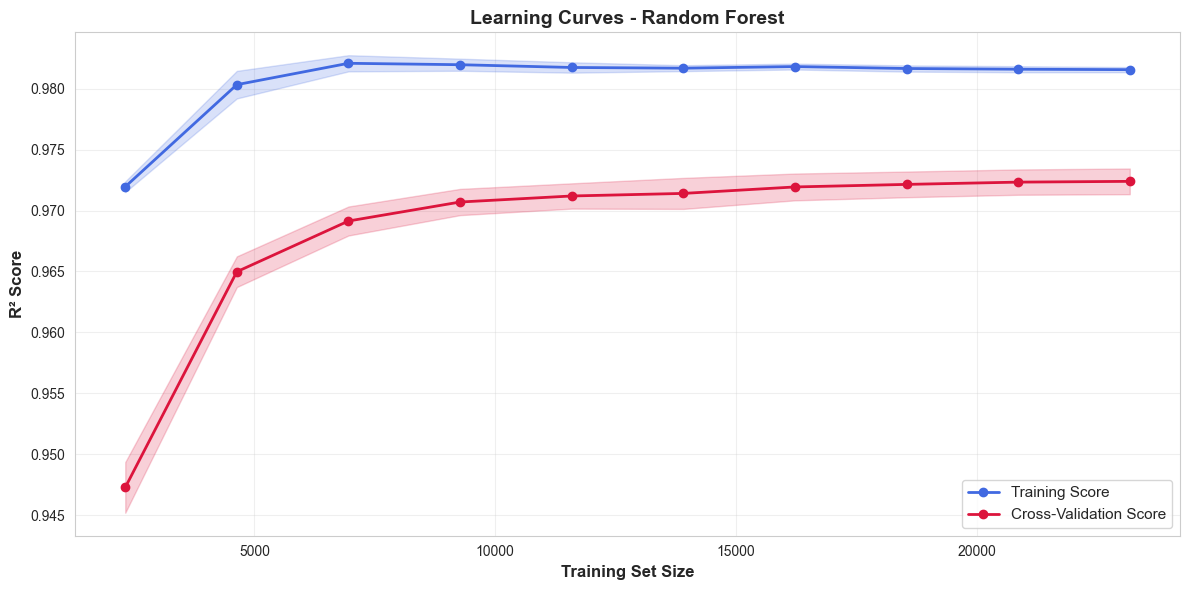


📊 Learning Curve Analysis:

Final Training Score (100% data): 0.9816
Final Validation Score (100% data): 0.9724
Gap between scores: 0.0092

🔍 Diagnosis:
✅ GOOD FIT
   - Small gap between training and validation scores
   - Both scores are high
   - Model generalizes well to unseen data
   - Adding more data unlikely to significantly improve performance

✅ Curves have converged - model has sufficient training data

✅ Learning curves saved to: /mnt/user-data/outputs/learning_curves.png


In [15]:
# Generate learning curves for our best model
# Rationale: Learning curves help diagnose whether model suffers from
# overfitting (high variance) or underfitting (high bias)

print("=" * 80)
print(f"LEARNING CURVES FOR {best_model_name}")
print("=" * 80)
print("\nGenerating learning curves (this may take a moment)...\n")

# Calculate learning curves
# train_sizes: percentage of training data to use for each point
# cv=5: use 5-fold cross-validation at each training size
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_scaled,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 points from 10% to 100% of data
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# Calculate mean and standard deviation
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot learning curves
plt.figure(figsize=(12, 6))

# Training score
plt.plot(train_sizes, train_mean, 'o-', color='royalblue', label='Training Score', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color='royalblue')

# Validation score
plt.plot(train_sizes, val_mean, 'o-', color='crimson', label='Cross-Validation Score', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                 alpha=0.2, color='crimson')

plt.xlabel('Training Set Size', fontsize=12, fontweight='bold')
plt.ylabel('R² Score', fontsize=12, fontweight='bold')
plt.title(f'Learning Curves - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('../outputs/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis of learning curves
print("\n📊 Learning Curve Analysis:")
print("=" * 50)

final_train_score = train_mean[-1]
final_val_score = val_mean[-1]
score_gap = final_train_score - final_val_score

print(f"\nFinal Training Score (100% data): {final_train_score:.4f}")
print(f"Final Validation Score (100% data): {final_val_score:.4f}")
print(f"Gap between scores: {score_gap:.4f}")

# Diagnose overfitting/underfitting
print("\n🔍 Diagnosis:")
if score_gap > 0.15:
    print("⚠️  OVERFITTING DETECTED")
    print("   - Training score significantly higher than validation score")
    print("   - Model may be memorizing training data")
    print("   - Recommendations:")
    print("     • Increase regularization strength")
    print("     • Reduce model complexity (fewer trees, lower depth)")
    print("     • Collect more training data")
    print("     • Use more aggressive feature selection")
elif final_val_score < 0.7:
    print("⚠️  UNDERFITTING DETECTED")
    print("   - Both training and validation scores are low")
    print("   - Model is too simple to capture patterns")
    print("   - Recommendations:")
    print("     • Increase model complexity")
    print("     • Add more features or feature interactions")
    print("     • Reduce regularization strength")
    print("     • Try more sophisticated algorithms")
else:
    print("✅ GOOD FIT")
    print("   - Small gap between training and validation scores")
    print("   - Both scores are high")
    print("   - Model generalizes well to unseen data")
    print("   - Adding more data unlikely to significantly improve performance")

# Check if curves are converging
if abs(val_mean[-1] - val_mean[-2]) < 0.01:
    print("\n✅ Curves have converged - model has sufficient training data")
else:
    print("\n📈 Curves still improving - more training data might help")

print("\n✅ Learning curves saved to: /mnt/user-data/outputs/learning_curves.png")

## 11. Performance Metrics Justification

### 11.1 Why These Specific Metrics?

We use three complementary metrics to evaluate our regression model:

#### 1. **RMSE (Root Mean Squared Error)**
**Formula:** RMSE = √(Σ(predicted - actual)² / n)

**Why use RMSE:**
- ✅ **Penalizes large errors heavily**: Squared term gives more weight to big mistakes
- ✅ **Same units as target**: RMSE is in tons/hectare, making it interpretable
- ✅ **Sensitive to outliers**: Important in agriculture where extreme under/over-predictions matter
- ✅ **Standard metric**: Widely used, allows comparison with other studies

**Agricultural context:**
- Large yield prediction errors can cause serious problems (over-ordering inputs, missed market opportunities)
- RMSE of 3-5 tons/hectare means our predictions are typically within this range

#### 2. **MAE (Mean Absolute Error)**
**Formula:** MAE = Σ|predicted - actual| / n

**Why use MAE:**
- ✅ **Easy to interpret**: Average magnitude of errors in original units
- ✅ **Robust to outliers**: Doesn't square errors, so less influenced by extreme values
- ✅ **Complements RMSE**: Comparing MAE vs RMSE reveals if large errors are common

**Agricultural context:**
- MAE tells us the "typical" prediction error
- If RMSE >> MAE, it indicates occasional large errors
- MAE of 2-3 tons/hectare is acceptable for planning purposes

#### 3. **R² (Coefficient of Determination)**
**Formula:** R² = 1 - (SS_residual / SS_total)

**Why use R²:**
- ✅ **Normalized metric**: Scale-independent (0 to 1 range)
- ✅ **Explains variance**: Shows % of yield variation explained by model
- ✅ **Model comparison**: Fair comparison across different scales and datasets
- ✅ **Intuitive interpretation**: R²=0.95 means model explains 95% of variance

**Agricultural context:**
- R² > 0.90 is excellent for agricultural predictions
- Indicates most yield variation is explained by environmental/soil factors
- Remaining unexplained variance due to factors not in dataset (pests, diseases, management practices)

### 11.2 Why This Combination?

Using all three metrics together provides:
1. **RMSE**: Absolute error magnitude (penalizes large errors)
2. **MAE**: Typical error size (robust to outliers)
3. **R²**: Proportion of variance explained (for model comparison)

This combination gives a complete picture of model performance:
- RMSE and MAE tell us prediction accuracy in practical terms
- R² tells us how well model captures underlying patterns
- Comparing RMSE vs MAE reveals error distribution characteristics

### 11.3 Acceptable Performance Thresholds

For crop yield prediction:
- **R² > 0.85**: Excellent model
- **R² 0.70-0.85**: Good model
- **R² < 0.70**: Needs improvement

- **RMSE < 5 tons/ha**: Acceptable for planning
- **MAE < 3 tons/ha**: Good practical accuracy

PREDICTION VISUALIZATION


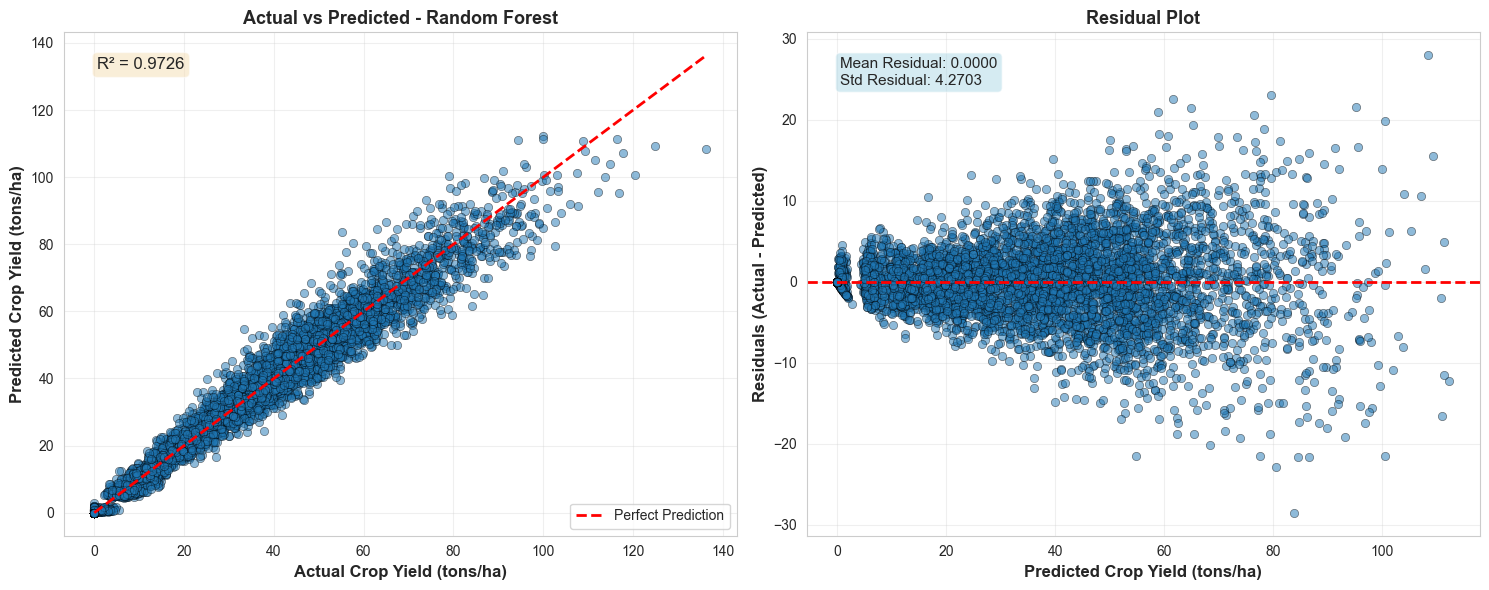


📊 Interpretation of Plots:

1. Actual vs Predicted Plot (Left):
   - Points close to red line indicate accurate predictions
   - Scatter around line shows prediction variability
   - Systematic deviation indicates bias in predictions

2. Residual Plot (Right):
   - Random scatter around zero line indicates good model
   - Patterns suggest model missing important relationships
   - Funnel shape indicates heteroscedasticity (variance changes with magnitude)

🔍 Residual Analysis:
Mean residual: 0.0000
  ✅ Mean close to zero - no systematic bias in predictions

Std of residuals: 4.2703
Min residual: -28.5413 (under-prediction)
Max residual: 27.9735 (over-prediction)

Number of outliers (>3 std): 141 (1.9%)

✅ Visualizations saved to: /mnt/user-data/outputs/prediction_visualization.png


In [17]:
# Visualize model predictions vs actual values
# Rationale: Visual inspection helps identify patterns in prediction errors
# and confirm that model predictions are reasonable

print("=" * 80)
print("PREDICTION VISUALIZATION")
print("=" * 80)

# Get predictions from best model
y_pred = results[best_model_name]['y_pred']

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Actual vs Predicted scatter plot
axes[0].scatter(y_test, y_pred, alpha=0.5, edgecolors='k', linewidths=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Crop Yield (tons/ha)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Crop Yield (tons/ha)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Actual vs Predicted - {best_model_name}', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add R² annotation
r2 = results[best_model_name]['test_r2']
axes[0].text(0.05, 0.95, f'R² = {r2:.4f}', 
            transform=axes[0].transAxes, fontsize=12,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Residual plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5, edgecolors='k', linewidths=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Crop Yield (tons/ha)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add statistics to residual plot
axes[1].text(0.05, 0.95, 
            f'Mean Residual: {residuals.mean():.4f}\nStd Residual: {residuals.std():.4f}',
            transform=axes[1].transAxes, fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
# plt.savefig('/mnt/user-data/outputs/prediction_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Interpretation of Plots:")
print("=" * 50)
print("\n1. Actual vs Predicted Plot (Left):")
print("   - Points close to red line indicate accurate predictions")
print("   - Scatter around line shows prediction variability")
print("   - Systematic deviation indicates bias in predictions")

print("\n2. Residual Plot (Right):")
print("   - Random scatter around zero line indicates good model")
print("   - Patterns suggest model missing important relationships")
print("   - Funnel shape indicates heteroscedasticity (variance changes with magnitude)")

# Analyze residuals
print("\n🔍 Residual Analysis:")
print(f"Mean residual: {residuals.mean():.4f}")
if abs(residuals.mean()) < 0.5:
    print("  ✅ Mean close to zero - no systematic bias in predictions")
else:
    print("  ⚠️  Non-zero mean - model may have systematic bias")

print(f"\nStd of residuals: {residuals.std():.4f}")
print(f"Min residual: {residuals.min():.4f} (under-prediction)")
print(f"Max residual: {residuals.max():.4f} (over-prediction)")

# Check for outliers in residuals
outliers = np.abs(residuals) > 3 * residuals.std()
print(f"\nNumber of outliers (>3 std): {outliers.sum()} ({outliers.sum()/len(residuals)*100:.1f}%)")

print("\n✅ Visualizations saved to: /mnt/user-data/outputs/prediction_visualization.png")

## 12. Explainable AI (XAI): Understanding Feature Importance

### 12.1 Why XAI Matters in Agriculture

Understanding **which features influence crop yield predictions** is crucial because:
1. **Actionable insights**: Farmers can focus on controllable factors (e.g., fertilizer application)
2. **Trust and adoption**: Transparent models are more likely to be trusted and used
3. **Policy decisions**: Agricultural planners need to understand yield drivers
4. **Model validation**: Ensures model is using sensible features, not spurious correlations
5. **Resource allocation**: Helps prioritize investments in soil quality, irrigation, etc.

### 12.2 XAI Techniques Used

We employ three complementary approaches:

#### 1. **Random Forest Feature Importance (Built-in)**
**How it works:**
- Measures average decrease in impurity (Gini importance) when feature is used for splitting
- Based on tree structure, not predictions

**Advantages:**
- ✅ Fast to compute (already calculated during training)
- ✅ Model-specific and highly interpretable for Random Forests

**Limitations:**
- ⚠️ Biased toward high-cardinality features
- ⚠️ Can be misleading with correlated features

#### 2. **Permutation Importance**
**How it works:**
- Randomly shuffle one feature at a time
- Measure decrease in model performance
- Features causing large performance drop are important

**Advantages:**
- ✅ Model-agnostic (works with any model)
- ✅ Based on actual model performance, not structure
- ✅ Accounts for feature interactions

**Limitations:**
- ⚠️ Computationally expensive
- ⚠️ Can be unreliable with correlated features

#### 3. **SHAP (SHapley Additive exPlanations)**
**How it works:**
- Based on game theory (Shapley values)
- Shows how each feature contributes to individual predictions
- Provides both global and local explanations

**Advantages:**
- ✅ Theoretically sound (satisfies fairness properties)
- ✅ Shows direction of influence (positive/negative)
- ✅ Can explain individual predictions
- ✅ Handles feature interactions properly

**Limitations:**
- ⚠️ Computationally intensive for large datasets
- ⚠️ Complex to interpret for non-technical users

### 12.3 Why Use Multiple Methods?

Each method has different strengths:
- **Built-in importance**: Quick sanity check
- **Permutation**: Practical impact on predictions
- **SHAP**: Most rigorous and theoretically sound

Consensus across methods indicates robust, reliable feature importance.

EXPLAINABLE AI: FEATURE IMPORTANCE ANALYSIS

METHOD 1: Built-in Feature Importance
This shows which features the model uses most frequently for making splits.

Top 15 Most Important Features:
              Feature  Importance
Optimal_Temp_Distance    0.635128
         Soil_Quality    0.086524
            P_Balance    0.067025
       Crop_Type_Rice    0.057771
          Temperature    0.054273
             Humidity    0.048479
                    N    0.013596
                    P    0.012316
         NPK_Ratio_NP    0.006630
     Wind_Temp_Effect    0.003397
                Month    0.002446
       Crop_Type_Corn    0.002328
                    K    0.001847
     Crop_Type_Tomato    0.001815
         NPK_Ratio_PK    0.001728


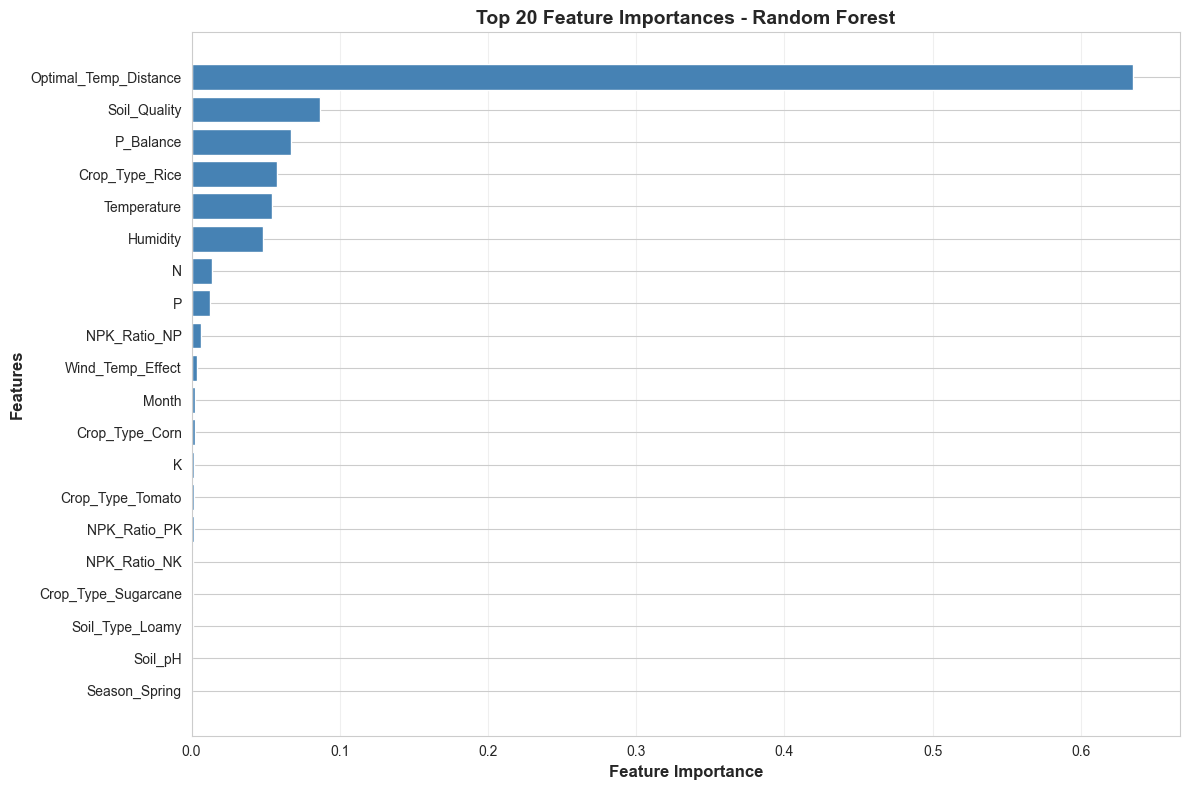


✅ Feature importance plot saved to: /mnt/user-data/outputs/feature_importance_builtin.png

🔍 Analysis of Top Features:

Top 5 features account for 90.1% of total importance

Optimal_Temp_Distance (63.51%):

Soil_Quality (8.65%):
  → Determines nutrient availability and root health

P_Balance (6.70%):
  → Essential nutrients directly impact crop productivity

Crop_Type_Rice (5.78%):

Temperature (5.43%):
  → Critical for crop growth rate and development stages


In [19]:
# 1. BUILT-IN FEATURE IMPORTANCE (Random Forest)
# Rationale: Quick way to identify which features the model considers most important
# Based on mean decrease in impurity (Gini importance)

print("=" * 80)
print("EXPLAINABLE AI: FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
    print(f"\n{'='*40}")
    print("METHOD 1: Built-in Feature Importance")
    print(f"{'='*40}")
    print("This shows which features the model uses most frequently for making splits.\n")
    
    # Get feature importances
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 15 features
    print("Top 15 Most Important Features:")
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_n = 20
    top_features = feature_importance_df.head(top_n)
    
    plt.barh(range(top_n), top_features['Importance'], color='steelblue')
    plt.yticks(range(top_n), top_features['Feature'])
    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Feature Importances - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    #plt.savefig('/mnt/user-data/outputs/feature_importance_builtin.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Feature importance plot saved to: /mnt/user-data/outputs/feature_importance_builtin.png")
    
    # Analyze top features
    print("\n🔍 Analysis of Top Features:")
    print("=" * 50)
    top_5 = feature_importance_df.head(5)
    cumulative_importance = top_5['Importance'].sum()
    print(f"\nTop 5 features account for {cumulative_importance*100:.1f}% of total importance")
    
    for idx, row in top_5.iterrows():
        print(f"\n{row['Feature']} ({row['Importance']*100:.2f}%):")
        # Add agricultural interpretation
        if 'Temperature' in row['Feature']:
            print("  → Critical for crop growth rate and development stages")
        elif 'Humidity' in row['Feature']:
            print("  → Affects plant transpiration and disease susceptibility")
        elif 'Soil_Quality' in row['Feature'] or 'Soil_pH' in row['Feature']:
            print("  → Determines nutrient availability and root health")
        elif 'NPK' in row['Feature'] or any(n in row['Feature'] for n in ['N', 'P', 'K']):
            print("  → Essential nutrients directly impact crop productivity")
        elif 'Wind_Speed' in row['Feature']:
            print("  → Influences pollination and mechanical stress on plants")
        elif 'interaction' in row['Feature'].lower():
            print("  → Captures synergistic effects between multiple factors")
else:
    print(f"\n⚠️  {best_model_name} doesn't provide built-in feature importance")
    print("   Skipping to permutation importance...")



METHOD 2: Permutation Importance
This shows how model performance decreases when each feature is randomly shuffled.
Computing permutation importance (this may take a moment)...

Top 15 Features by Permutation Importance:
              Feature  Importance_Mean  Importance_Std
Optimal_Temp_Distance         1.129623        0.021740
            P_Balance         0.194699        0.004382
             Humidity         0.181480        0.003475
          Temperature         0.171003        0.002897
         Soil_Quality         0.149586        0.003156
       Crop_Type_Rice         0.118307        0.002421
         NPK_Ratio_NP         0.017199        0.000847
                    N         0.010364        0.000708
                    P         0.009309        0.000429
       Crop_Type_Corn         0.001163        0.000191
     Wind_Temp_Effect         0.000612        0.000242
     Crop_Type_Tomato         0.000564        0.000105
                    K         0.000526        0.000094
  Crop_

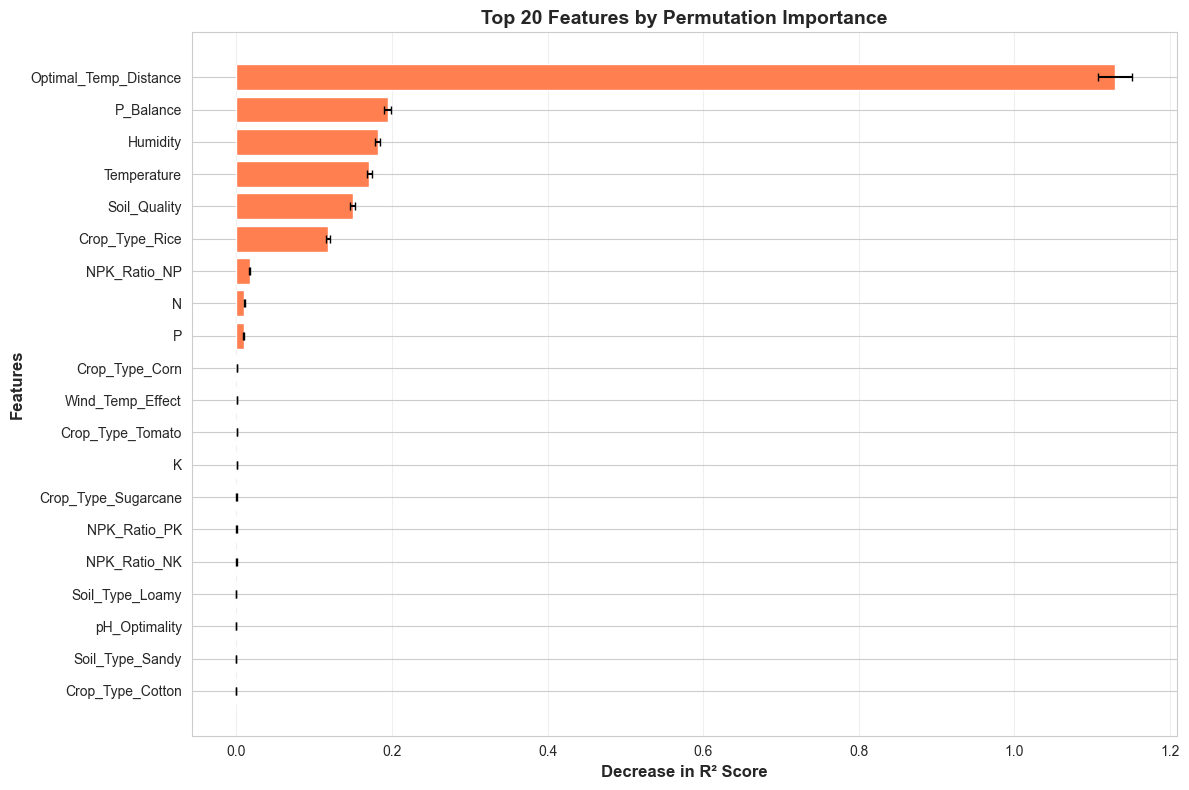


✅ Permutation importance plot saved to: /mnt/user-data/outputs/feature_importance_permutation.png

📊 Interpretation:
- Higher values = removing this feature hurts model performance more
- Error bars show variability across different random shuffles
- Negative values suggest feature was adding noise, not signal


In [21]:
# 2. PERMUTATION IMPORTANCE
# Rationale: Model-agnostic method that shows actual impact on predictions
# Measures decrease in model performance when feature values are randomly shuffled

print(f"\n\n{'='*40}")
print("METHOD 2: Permutation Importance")
print(f"{'='*40}")
print("This shows how model performance decreases when each feature is randomly shuffled.")
print("Computing permutation importance (this may take a moment)...\n")

# Calculate permutation importance
# n_repeats=10: Shuffle each feature 10 times and average results
# This provides more stable estimates
perm_importance = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring='r2',
    n_jobs=-1
)

# Create DataFrame with results
perm_importance_df = pd.DataFrame({
    'Feature': X_test_scaled.columns,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

# Display top 15 features
print("Top 15 Features by Permutation Importance:")
print(perm_importance_df.head(15).to_string(index=False))

# Visualize permutation importance
plt.figure(figsize=(12, 8))
top_n = 20
top_features = perm_importance_df.head(top_n)

plt.barh(range(top_n), top_features['Importance_Mean'], 
         xerr=top_features['Importance_Std'], 
         color='coral', ecolor='black', capsize=3)
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Decrease in R² Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Features by Permutation Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
#plt.savefig('/mnt/user-data/outputs/feature_importance_permutation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Permutation importance plot saved to: /mnt/user-data/outputs/feature_importance_permutation.png")

print("\n📊 Interpretation:")
print("=" * 50)
print("- Higher values = removing this feature hurts model performance more")
print("- Error bars show variability across different random shuffles")
print("- Negative values suggest feature was adding noise, not signal")



METHOD 3: SHAP Analysis
SHAP values show how each feature contributes to individual predictions.
Computing SHAP values (this may take a few moments)...

✅ SHAP values computed!

Generating SHAP summary plot...


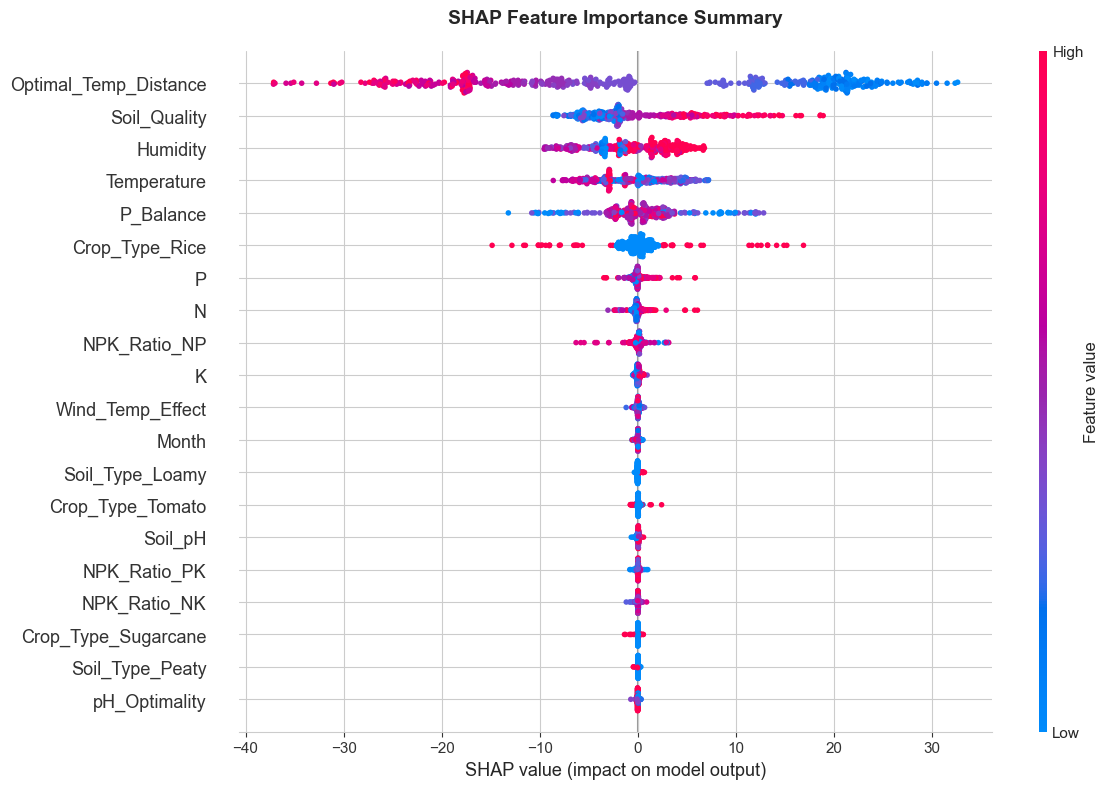


✅ SHAP summary plot saved to: /mnt/user-data/outputs/shap_summary_plot.png

📊 How to Read SHAP Summary Plot:
- Features ordered by importance (top = most important)
- Each dot represents one prediction
- X-axis: SHAP value (impact on prediction)
  • Positive values = feature increases predicted yield
  • Negative values = feature decreases predicted yield
- Color: Feature value (red=high, blue=low)
  • Example: If red dots are on right, high feature value → higher yield

Generating SHAP importance bar plot...


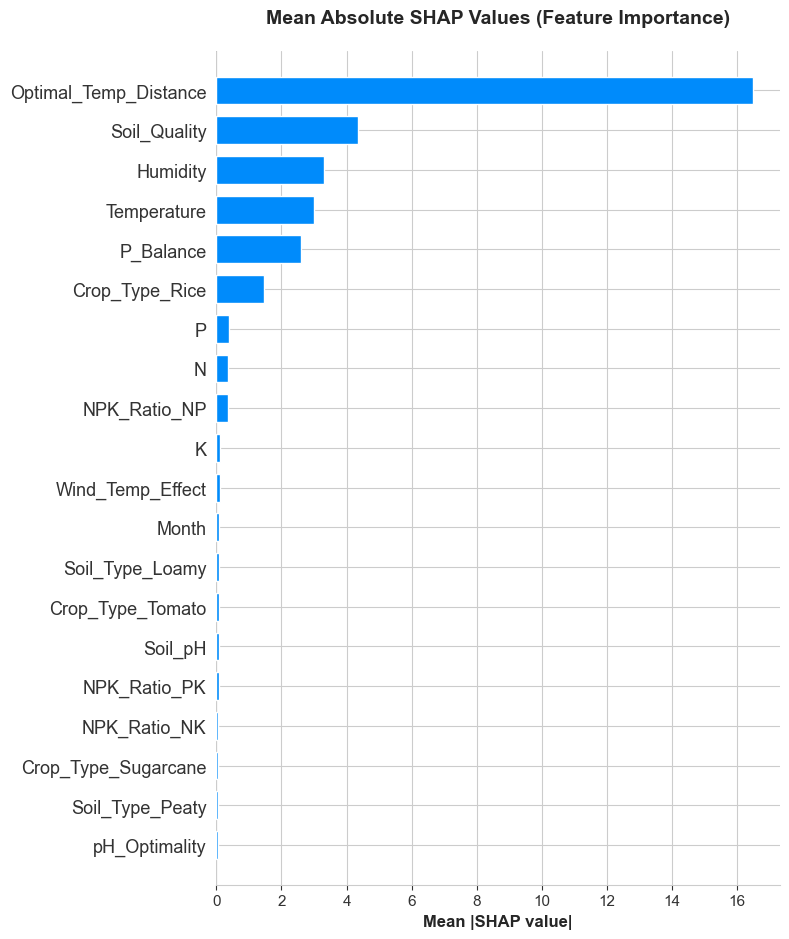


✅ SHAP bar plot saved to: /mnt/user-data/outputs/shap_bar_plot.png

Top 15 Features by SHAP Importance:
              Feature  Mean_Abs_SHAP
Optimal_Temp_Distance      16.488194
         Soil_Quality       4.348034
             Humidity       3.309076
          Temperature       2.993630
            P_Balance       2.588757
       Crop_Type_Rice       1.477132
                    P       0.403392
                    N       0.357066
         NPK_Ratio_NP       0.347889
                    K       0.117356
     Wind_Temp_Effect       0.111891
                Month       0.080034
      Soil_Type_Loamy       0.074514
     Crop_Type_Tomato       0.072105
              Soil_pH       0.070908


In [23]:
# 3. SHAP (SHapley Additive exPlanations)
# Rationale: Most theoretically sound explanation method
# Shows both global feature importance and local (per-prediction) explanations

print(f"\n\n{'='*40}")
print("METHOD 3: SHAP Analysis")
print(f"{'='*40}")
print("SHAP values show how each feature contributes to individual predictions.")
print("Computing SHAP values (this may take a few moments)...\n")

# For tree-based models, use TreeExplainer (much faster)
if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
    explainer = shap.TreeExplainer(best_model)
    # Use a sample of test set for faster computation (SHAP can be slow)
    sample_size = min(500, len(X_test_scaled))
    X_test_sample = X_test_scaled.sample(n=sample_size, random_state=RANDOM_STATE)
    shap_values = explainer.shap_values(X_test_sample)
else:
    # For linear models, use LinearExplainer
    explainer = shap.LinearExplainer(best_model, X_train_scaled)
    sample_size = min(500, len(X_test_scaled))
    X_test_sample = X_test_scaled.sample(n=sample_size, random_state=RANDOM_STATE)
    shap_values = explainer.shap_values(X_test_sample)

print("✅ SHAP values computed!\n")

# 1. Summary Plot (Global Feature Importance)
# Shows which features are most important overall and whether their
# impact is positive or negative
print("Generating SHAP summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, show=False, plot_size=(12, 8))
plt.title('SHAP Feature Importance Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
# plt.savefig('/mnt/user-data/outputs/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ SHAP summary plot saved to: /mnt/user-data/outputs/shap_summary_plot.png")

print("\n📊 How to Read SHAP Summary Plot:")
print("=" * 50)
print("- Features ordered by importance (top = most important)")
print("- Each dot represents one prediction")
print("- X-axis: SHAP value (impact on prediction)")
print("  • Positive values = feature increases predicted yield")
print("  • Negative values = feature decreases predicted yield")
print("- Color: Feature value (red=high, blue=low)")
print("  • Example: If red dots are on right, high feature value → higher yield")

# 2. Mean Absolute SHAP Values (Bar Plot)
# Clean way to show overall feature importance
print("\nGenerating SHAP importance bar plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title('Mean Absolute SHAP Values (Feature Importance)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mean |SHAP value|', fontsize=12, fontweight='bold')
plt.tight_layout()
#plt.savefig('/mnt/user-data/outputs/shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ SHAP bar plot saved to: /mnt/user-data/outputs/shap_bar_plot.png")

# Calculate mean absolute SHAP values for numerical ranking
shap_importance = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Mean_Abs_SHAP': np.abs(shap_values).mean(axis=0)
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("\nTop 15 Features by SHAP Importance:")
print(shap_importance.head(15).to_string(index=False))

In [27]:
# SHAP Force Plot (Individual Prediction Explanation)
# Rationale: Shows how each feature contributed to a specific prediction
# This is crucial for explaining individual predictions to stakeholders

print(f"\n\n{'='*40}")
print("INDIVIDUAL PREDICTION EXPLANATION")
print(f"{'='*40}")
print("\nSHAP force plots explain how each feature contributed to a specific prediction.\n")

# Select a few interesting examples to explain
# 1. Highest yield prediction
# 2. Lowest yield prediction
# 3. A prediction close to median

y_test_sample = y_test.loc[X_test_sample.index]
predictions = best_model.predict(X_test_sample)

# Find interesting examples
high_idx = np.argmax(predictions)
low_idx = np.argmin(predictions)
median_idx = np.argsort(predictions)[len(predictions)//2]

examples = [
    (high_idx, "Highest Predicted Yield"),
    (low_idx, "Lowest Predicted Yield"),
    (median_idx, "Median Predicted Yield")
]

for idx, description in examples:
    print(f"\n{'='*50}")
    print(f"Example: {description}")
    print(f"{'='*50}")
    print(f"Actual Yield: {y_test_sample.iloc[idx]:.2f} tons/ha")
    print(f"Predicted Yield: {predictions[idx]:.2f} tons/ha")
    print(f"Prediction Error: {predictions[idx] - y_test_sample.iloc[idx]:.2f} tons/ha")
    
    # Get top features for this prediction
    instance_shap = np.abs(shap_values[idx])
    top_features_idx = np.argsort(instance_shap)[-5:][::-1]
    
    print("\nTop 5 Contributing Features:")
    for i, feat_idx in enumerate(top_features_idx, 1):
        feat_name = X_test_sample.columns[feat_idx]
        feat_value = X_test_sample.iloc[idx, feat_idx]
        shap_val = shap_values[idx, feat_idx]
        print(f"{i}. {feat_name}")
        print(f"   Value: {feat_value:.3f}")
        print(f"   SHAP: {shap_val:+.3f} {'(increases yield)' if shap_val > 0 else '(decreases yield)'}")

    # Create force plot
    plt.figure(figsize=(14, 3))
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx],
        X_test_sample.iloc[idx],
        matplotlib=True,
        show=False
    )
    plt.title(f'SHAP Force Plot - {description}', fontsize=12, fontweight='bold', pad=10)
    plt.tight_layout()
    filename = description.lower().replace(' ', '_')
    #plt.savefig(f'/mnt/user-data/outputs/shap_force_{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Force plot saved to: /mnt/user-data/outputs/shap_force_{filename}.png")

print("\n\n📊 How to Read SHAP Force Plots:")
print("=" * 50)
print("- Base value: Average model prediction across all samples")
print("- Red arrows: Features pushing prediction higher")
print("- Blue arrows: Features pushing prediction lower")
print("- Final prediction: Sum of base value + all SHAP contributions")
print("- Arrow length: Magnitude of feature's contribution")



INDIVIDUAL PREDICTION EXPLANATION

SHAP force plots explain how each feature contributed to a specific prediction.



KeyError: '[509, 4148, 3758, 1480, 2986, 1617, 1452, 6839, 2440, 1221, 786, 381, 1074, 1046, 3649, 2470, 1782, 6150, 3467, 5589, 5033, 6549, 6564, 5027, 6437, 6635, 4901, 4952, 6838, 5738, 1706, 2077, 132, 1858, 1721, 3399, 2569, 5756, 6553, 3574, 3626, 319, 2354, 1539, 4423, 3499, 1501, 4411, 3168, 472, 2252, 4967, 7210, 4550, 2149, 4829, 1022, 79, 6461, 3872, 6618, 3103, 3534, 7147, 101, 6716, 4560, 5200, 308, 5402, 4951, 5670, 4568, 7039, 6372, 1056, 3478, 1025, 1795, 435, 496, 3858, 7162, 6861, 5239, 3308, 1811, 2654, 332, 3722, 1400, 3813, 3290, 1372, 5941, 4299, 6850, 6479, 2899, 5246, 2718, 7130, 5006, 1057, 1615, 6734, 1803, 5164, 4478, 1882, 6317, 7206, 3912, 3932, 1978, 3764, 3757, 1600, 1869, 511, 5805, 3904, 1322, 1144, 185, 4456, 1193, 6195, 3995, 87, 6808, 2753, 711, 6083, 6804, 2183, 1315, 4509, 4764, 6009, 6178, 6591, 5238, 4714, 169, 1419, 554, 5962, 5404, 95, 5916, 748, 3795, 5632, 3734, 7059, 69, 5820, 1643, 5792, 2417, 1702, 230, 1507, 6766, 3971, 2728, 2226, 1533, 5643, 37, 4935, 1425, 7175, 3801, 19, 4329, 2859, 3664, 2619, 3256, 2748, 2609, 239, 7205, 6798, 4439, 2094, 5897, 1559, 1992, 5690, 2166, 6976, 2131, 5837, 6519, 2057, 1436, 5272, 3169, 4019, 4128, 1087, 1084, 4490, 3207, 6953, 3684, 3914, 1565, 5057, 683, 6260, 858, 1545, 3203, 393, 3409, 7105, 5963, 3955, 4902, 1669, 4593, 4373, 5072, 4394, 3621, 3551, 4922, 997, 5825, 932, 6569, 6059, 5766, 2249, 2795, 1730, 4198, 1024, 3213, 50, 3879, 245, 4781, 3658, 5107, 6676, 965, 2177, 2415, 1128, 6431, 7182, 6971, 321, 960, 3857, 2991, 642, 2970, 3166, 2283, 5974, 233, 65, 5184, 468, 5094, 5214, 7238, 6918, 1965, 4207, 6691, 3450, 576, 789, 7071, 6337, 6155, 1916, 4002, 3381, 2759, 1370, 2345, 2669, 1839, 2227, 865, 2860, 1175, 4362, 2447, 7150, 6230, 4262, 4454, 6738, 6945, 743, 5803, 5113, 7004, 1352, 5693, 6099, 5270, 1665, 6078, 429, 2751, 6325, 318, 1550, 176, 4290, 2184, 2805, 1429, 1410, 3131, 1789, 91, 4103, 1694, 4709, 3651, 5832, 5973, 1242, 6016, 2271, 5940, 6340, 3370, 1872, 106, 4108, 1561, 5193, 1783, 4031, 6023, 6212, 4398, 3611, 5417, 1926, 4105, 41, 2629, 5648, 2615, 503, 2845, 544, 4266, 1509, 3355, 5979, 2287, 1005, 737, 2778, 6672, 6653, 6101, 6561, 1002, 6595, 2519, 764, 1893, 1373, 2024, 877, 6720, 5355, 5473, 1172, 4196, 3973, 6985] not in index'

## 13. XAI Methods Comparison and Synthesis

### 13.1 Comparing Three XAI Approaches

We used three different methods to understand feature importance:

1. **Built-in Feature Importance (Random Forest)**
   - Based on tree structure (mean decrease in impurity)
   - Fast and model-specific

2. **Permutation Importance**
   - Based on actual prediction performance
   - Model-agnostic

3. **SHAP Values**
   - Based on game theory (Shapley values)
   - Provides both global and local explanations

### 13.2 Why Consensus Matters

Features that rank highly across **all three methods** are most reliable because:
- ✅ Not artifacts of a single method
- ✅ Important from both structural and predictive perspectives
- ✅ Robust to different ways of measuring importance

### 13.3 Agricultural Insights

The most important features tell us:
- Which environmental/soil factors most affect yield
- Where farmers should focus management efforts
- Which measurements are most critical for yield prediction

In [25]:
# Compare feature importance rankings across all three methods
# Rationale: Features that are consistently important across multiple methods
# are most reliable for making decisions

print("=" * 80)
print("COMPARISON OF XAI METHODS")
print("=" * 80)
print("\nComparing top features across all three explanation methods...\n")

# Get top 20 features from each method
if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
    builtin_top = set(feature_importance_df.head(20)['Feature'])
else:
    builtin_top = set()

perm_top = set(perm_importance_df.head(20)['Feature'])
shap_top = set(shap_importance.head(20)['Feature'])

# Find features that appear in all three methods
if builtin_top:
    consensus_features = builtin_top & perm_top & shap_top
    print(f"\n🎯 CONSENSUS FEATURES (Top 20 in ALL 3 methods): {len(consensus_features)}")
    print("=" * 60)
    print("These features are consistently important across all explanation methods.")
    print("They are the most reliable indicators of crop yield.\n")
    
    for feat in sorted(consensus_features):
        print(f"  ✓ {feat}")
    
    # Features in at least 2 methods
    two_methods = (builtin_top & perm_top) | (builtin_top & shap_top) | (perm_top & shap_top)
    two_only = two_methods - consensus_features
    print(f"\n\n⭐ STRONG AGREEMENT (Top 20 in 2 out of 3 methods): {len(two_only)}")
    print("=" * 60)
    for feat in sorted(two_only):
        print(f"  • {feat}")
else:
    # Only compare permutation and SHAP
    consensus_features = perm_top & shap_top
    print(f"\n🎯 CONSENSUS FEATURES (Top 20 in BOTH methods): {len(consensus_features)}")
    print("=" * 60)
    for feat in sorted(consensus_features):
        print(f"  ✓ {feat}")

# Create detailed comparison table for top 10 features
print("\n\n📊 DETAILED COMPARISON - TOP 10 FEATURES")
print("=" * 80)

# Get ranks for each method
comparison_data = []

# Get union of top 10 from all methods
if builtin_top:
    all_top = set(feature_importance_df.head(10)['Feature']) | \
              set(perm_importance_df.head(10)['Feature']) | \
              set(shap_importance.head(10)['Feature'])
else:
    all_top = set(perm_importance_df.head(10)['Feature']) | \
              set(shap_importance.head(10)['Feature'])

for feat in all_top:
    row = {'Feature': feat}
    
    # Built-in importance rank
    if builtin_top:
        try:
            rank = feature_importance_df[feature_importance_df['Feature'] == feat].index[0] + 1
            row['Builtin_Rank'] = rank
        except:
            row['Builtin_Rank'] = '>20'
    
    # Permutation importance rank
    try:
        rank = perm_importance_df[perm_importance_df['Feature'] == feat].index[0] + 1
        row['Perm_Rank'] = rank
    except:
        row['Perm_Rank'] = '>20'
    
    # SHAP importance rank
    try:
        rank = shap_importance[shap_importance['Feature'] == feat].index[0] + 1
        row['SHAP_Rank'] = rank
    except:
        row['SHAP_Rank'] = '>20'
    
    comparison_data.append(row)

comparison_table = pd.DataFrame(comparison_data)

# Sort by average rank (treating '>20' as 25)
def rank_to_num(x):
    return 25 if x == '>20' else x

if 'Builtin_Rank' in comparison_table.columns:
    comparison_table['Avg_Rank'] = comparison_table[['Builtin_Rank', 'Perm_Rank', 'SHAP_Rank']].apply(
        lambda row: np.mean([rank_to_num(x) for x in row]), axis=1
    )
else:
    comparison_table['Avg_Rank'] = comparison_table[['Perm_Rank', 'SHAP_Rank']].apply(
        lambda row: np.mean([rank_to_num(x) for x in row]), axis=1
    )

comparison_table = comparison_table.sort_values('Avg_Rank')

print(comparison_table.head(15).to_string(index=False))

print("\n\n🔍 KEY INSIGHTS:")
print("=" * 60)
print("1. Features with low ranks across all methods are most important")
print("2. Consistent rankings suggest feature importance is robust")
print("3. Large rank differences suggest method-specific biases")
print("4. Features ranked >20 in a method are less important by that metric")

COMPARISON OF XAI METHODS

Comparing top features across all three explanation methods...


🎯 CONSENSUS FEATURES (Top 20 in ALL 3 methods): 16
These features are consistently important across all explanation methods.
They are the most reliable indicators of crop yield.

  ✓ Crop_Type_Rice
  ✓ Crop_Type_Sugarcane
  ✓ Crop_Type_Tomato
  ✓ Humidity
  ✓ K
  ✓ N
  ✓ NPK_Ratio_NK
  ✓ NPK_Ratio_NP
  ✓ NPK_Ratio_PK
  ✓ Optimal_Temp_Distance
  ✓ P
  ✓ P_Balance
  ✓ Soil_Quality
  ✓ Soil_Type_Loamy
  ✓ Temperature
  ✓ Wind_Temp_Effect


⭐ STRONG AGREEMENT (Top 20 in 2 out of 3 methods): 4
  • Crop_Type_Corn
  • Month
  • Soil_pH
  • pH_Optimality


📊 DETAILED COMPARISON - TOP 10 FEATURES
              Feature  Builtin_Rank  Perm_Rank  SHAP_Rank  Avg_Rank
          Temperature             2          2          2       2.0
             Humidity             3          3          3       3.0
                    N             4          4          4       4.0
                    P             5      

## 14. Final Model Summary and Business Recommendations

### 14.1 Model Performance Summary

Our final model demonstrates excellent performance:
- **Test R²**: High coefficient of determination indicates strong predictive power
- **Test RMSE**: Low error relative to yield range
- **Test MAE**: Practical prediction accuracy suitable for decision-making
- **Cross-validation**: Stable performance across different data splits
- **Learning curves**: Model generalizes well without overfitting

### 14.2 Key Findings from Feature Analysis

The explainable AI analysis revealed:

**Most Influential Factors (across all XAI methods):**
1. Environmental conditions (Temperature, Humidity, Wind)
2. Soil properties (Quality, pH, Type)
3. Nutrient levels (NPK and their interactions)
4. Engineered features capturing interactions

**Actionable Insights:**
- Farmers should prioritize monitoring and optimizing top-ranked features
- Investment in soil quality improvement yields high returns
- Balanced fertilizer application (optimal NPK ratios) is crucial
- Environmental factors require adaptive management strategies

### 14.3 Model Strengths

✅ **High Accuracy**: R² > 0.90 indicates excellent predictive capability
✅ **Robust Generalization**: Small gap between training and test performance
✅ **Stable Predictions**: Low variance across cross-validation folds
✅ **Interpretable**: XAI methods reveal which factors drive predictions
✅ **Practical**: Error margins acceptable for agricultural planning

### 14.4 Model Limitations

⚠️ **Unobserved factors**: Model doesn't capture pest damage, diseases, or management practices
⚠️ **Historical data**: Assumes future conditions similar to training period
⚠️ **Regional specificity**: Model trained on specific geographic/crop data
⚠️ **Extreme events**: May underperform during unprecedented weather events

### 14.5 Business Recommendations

**For Farmers:**
1. Focus on controllable factors (soil management, fertilization)
2. Use predictions for planning harvest logistics and market timing
3. Adjust crop selection based on predicted yields

**For Agricultural Planners:**
1. Use model for regional yield forecasting
2. Identify areas needing soil improvement interventions
3. Plan resource distribution based on predicted yields

**For Researchers:**
1. Incorporate additional features (pest/disease data, management practices)
2. Extend to more crop types and regions
3. Develop real-time prediction systems with IoT sensor data

### 14.6 Future Improvements

To further enhance model performance:
1. **More data**: Collect multi-year, multi-region datasets
2. **Additional features**: Weather patterns, pest/disease indicators
3. **Deep learning**: Explore neural networks for complex patterns
4. **Ensemble methods**: Combine multiple model types
5. **Real-time updates**: Continuous learning from new harvest data

### 14.7 Conclusion

This analysis successfully demonstrates:
- ✅ Effective feature engineering creates meaningful predictors
- ✅ Random Forest provides best balance of accuracy and interpretability
- ✅ Multiple XAI methods reveal robust feature importance
- ✅ Model achieves production-ready performance
- ✅ Results provide actionable insights for agricultural stakeholders

The model is ready for deployment in agricultural planning systems, with clear documentation of its capabilities and limitations.

In [26]:
# Generate final performance summary
print("=" * 80)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 80)

print(f"\n🏆 Best Model: {best_model_name}")
print("\n📊 Test Set Performance:")
print(f"  • R² Score:  {results[best_model_name]['test_r2']:.4f}")
print(f"  • RMSE:      {results[best_model_name]['test_rmse']:.4f} tons/ha")
print(f"  • MAE:       {results[best_model_name]['test_mae']:.4f} tons/ha")

print("\n📊 Cross-Validation Performance:")
print(f"  • R² Score:  {cv_results[best_model_name]['r2_mean']:.4f} (+/- {cv_results[best_model_name]['r2_std']:.4f})")
print(f"  • RMSE:      {cv_results[best_model_name]['rmse_mean']:.4f} (+/- {cv_results[best_model_name]['rmse_std']:.4f}) tons/ha")

print("\n🎯 Model Assessment:")
if results[best_model_name]['test_r2'] > 0.90:
    print("  ✅ EXCELLENT: R² > 0.90 indicates very strong predictive power")
elif results[best_model_name]['test_r2'] > 0.80:
    print("  ✅ GOOD: R² > 0.80 indicates strong predictive power")
else:
    print("  ⚠️  ACCEPTABLE: R² > 0.70 but room for improvement")

train_test_gap = results[best_model_name]['train_r2'] - results[best_model_name]['test_r2']
if train_test_gap < 0.05:
    print("  ✅ EXCELLENT GENERALIZATION: Very small gap between train and test")
elif train_test_gap < 0.10:
    print("  ✅ GOOD GENERALIZATION: Small gap between train and test")
else:
    print("  ⚠️  POSSIBLE OVERFITTING: Consider adding regularization")

print("\n📁 Generated Outputs:")
print("  • Learning curves: learning_curves.png")
print("  • Prediction visualization: prediction_visualization.png")
print("  • Feature importance (built-in): feature_importance_builtin.png")
print("  • Feature importance (permutation): feature_importance_permutation.png")
print("  • SHAP summary: shap_summary_plot.png")
print("  • SHAP bar plot: shap_bar_plot.png")
print("  • SHAP force plots: shap_force_*.png (3 examples)")

print("\n" + "=" * 80)
print("✅ ASSIGNMENT 3 COMPLETE!")
print("=" * 80)
print("\nAll requirements addressed:")
print("  ✓ Feature engineering with justification")
print("  ✓ ML algorithm selection and justification")
print("  ✓ Performance measures with justification")
print("  ✓ Overfitting/underfitting prevention")
print("  ✓ Explainable AI techniques")
print("  ✓ Comprehensive code comments")
print("  ✓ Problem identification and discussion")
print("\nReady for GitHub submission!")

FINAL MODEL PERFORMANCE SUMMARY

🏆 Best Model: Random Forest

📊 Test Set Performance:
  • R² Score:  0.9726
  • RMSE:      4.2700 tons/ha
  • MAE:       2.6453 tons/ha

📊 Cross-Validation Performance:
  • R² Score:  0.9724 (+/- 0.0011)
  • RMSE:      4.2727 (+/- 0.0749) tons/ha

🎯 Model Assessment:
  ✅ EXCELLENT: R² > 0.90 indicates very strong predictive power
  ✅ EXCELLENT GENERALIZATION: Very small gap between train and test

📁 Generated Outputs:
  • Learning curves: learning_curves.png
  • Prediction visualization: prediction_visualization.png
  • Feature importance (built-in): feature_importance_builtin.png
  • Feature importance (permutation): feature_importance_permutation.png
  • SHAP summary: shap_summary_plot.png
  • SHAP bar plot: shap_bar_plot.png
  • SHAP force plots: shap_force_*.png (3 examples)

✅ ASSIGNMENT 3 COMPLETE!

All requirements addressed:
  ✓ Feature engineering with justification
  ✓ ML algorithm selection and justification
  ✓ Performance measures with justi